# Wand2Vec

In this notebook I will be following the extremely useful word2vec representation here (https://github.com/YuriyGuts/thrones2vec), and apply it to the Harry Potter universe. 

In [1]:
import codecs
import glob
import logging
import os
import pprint
import re

import requests
import urllib.request

In [2]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/noahkasmanoff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noahkasmanoff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Prepare Corpus

I will be loading these books from glozman.com, and delete them at the end to preserve memory space. 

This is my own data scraping, so it's a quick detour from the method used in thrones2vec, and will be back to that method soon.

In [5]:
url1 = "http://www.glozman.com/TextPages/Harry%20Potter%201%20-%20Sorcerer's%20Stone.txt"
url2 = "http://www.glozman.com/TextPages/Harry%20Potter%202%20-%20Chamber%20of%20Secrets.txt"
url3 = "http://www.glozman.com/TextPages/Harry%20Potter%203%20-%20The%20Prisoner%20Of%20Azkaban.txt"
url4 = "http://www.glozman.com/TextPages/Harry%20Potter%204%20-%20The%20Goblet%20Of%20Fire.txt"
url5 = "http://www.glozman.com/TextPages/Harry%20Potter%205%20-%20Order%20of%20the%20Phoenix.txt"
url6 = "http://www.glozman.com/TextPages/Harry%20Potter%206%20-%20The%20Half%20Blood%20Prince.txt"
url7 = "http://www.glozman.com/TextPages/Harry%20Potter%207%20-%20Deathly%20Hollows.txt"
urls = [url1,url2,url3,url4,url5,url6,url7]

for i,url in enumerate(urls):
    response = requests.get(url)
    file = open("hp"+str(i+1)+".txt",'w')
    file.write(response.text)
    file.close()

In [6]:
book_filenames = sorted(glob.glob("*.txt"))


In [7]:
print("Found books:")
book_filenames

Found books:


['hp1.txt',
 'hp2.txt',
 'hp3.txt',
 'hp4.txt',
 'hp5.txt',
 'hp6.txt',
 'hp7.txt',
 'hp8.txt']

Now combine the book's into one file, aka a corpus. 

In [10]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'hp1.txt'...
Corpus is now 448810 characters long

Reading 'hp2.txt'...
Corpus is now 947729 characters long

Reading 'hp3.txt'...
Corpus is now 1569784 characters long

Reading 'hp4.txt'...
Corpus is now 2690176 characters long

Reading 'hp5.txt'...
Corpus is now 4190900 characters long

Reading 'hp6.txt'...
Corpus is now 5182402 characters long

Reading 'hp7.txt'...
Corpus is now 6321546 characters long

Reading 'hp8.txt'...
Corpus is now 6321546 characters long



Now split the corpus into sentences. The NLTK can tokenize it using the pnkt thing I already loaded. 

In [11]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


In [12]:
raw_sentences = tokenizer.tokenize(corpus_raw)


In [13]:
#Converts a sentence into a list of words, basically an array at a time where each word is separated by a comma. 
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [14]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [19]:
print(raw_sentences[500])
print(sentences[500])

Dudley quickly found the largest snake in the place.
['Dudley', 'quickly', 'found', 'the', 'largest', 'snake', 'in', 'the', 'place']


How many words are there? 

In [20]:

token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,120,879 tokens


# Now to train the Word2Vec

In [21]:
# Dimensionality of the resulting word vectors.
num_features = 360

# Minimum word count threshold.
min_word_count = 3


# Context window length.
context_size = 10

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [22]:
wand2vec  = w2v.Word2Vec(
    sg=1,
    seed=seed,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [23]:
wand2vec.build_vocab(sentences)


In [24]:
print("Word2Vec vocabulary length:", len(wand2vec.wv.vocab))


Word2Vec vocabulary length: 13183


Now it's training day!

In [30]:
#wand2vec.train(sentences=sentences, total_examples=len(wand2vec.wv.vocab))
wand2vec.train(sentences=sentences, total_examples=1, epochs=3)

#based on the documentation all of these parameters are set, and the optional ones are left out. 

(2547153, 3362637)

# Now to explore the trained model

In [31]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)


In [36]:
np.shape(wand2vec.wv.syn0)#these are the weights for each word, and where they are in the vector space. 

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


(13183, 360)

Based on this there are 13183 unique words.

Use manifolds for dimensionality reduction, and easy to visualize results.

In [32]:
all_word_vectors_matrix = wand2vec.wv.syn0


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


In [37]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)


In [38]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[wand2vec.wv.vocab[word].index])
            for word in wand2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [39]:
points.head(20)


,word,x,y
0,Harry,-38.193043,37.744873
1,Potter,-32.802605,38.383213
2,and,-38.854008,38.315567
3,the,-38.974232,38.358818
4,Sorcerer,12.591012,71.668839
5,s,-38.052170,34.236408
6,Stone,42.081898,61.096447
7,CHAPTER,0.746643,-69.330460
8,ONE,-4.012008,-67.748161
9,THE,-32.957752,-66.573547


In [40]:
sns.set_context("poster")


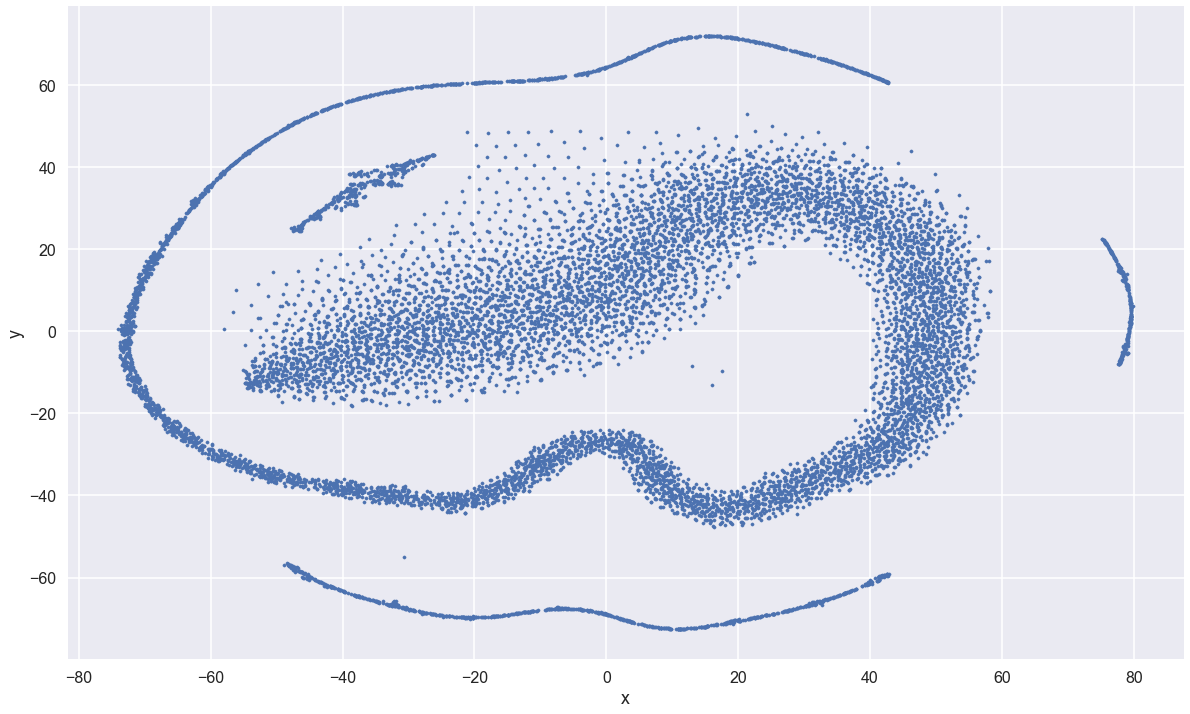

In [41]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))


In [42]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x, point.y, point.word, fontsize=11)

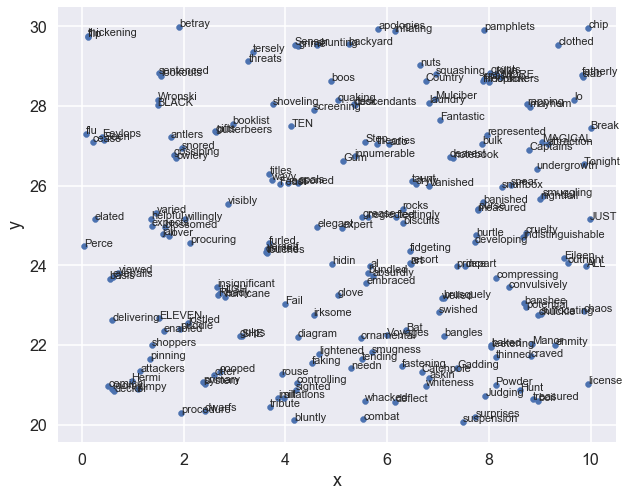

In [43]:
plot_region(x_bounds=(0, 10), y_bounds=(20, 30))


In [44]:
wand2vec.most_similar("Weasley")


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('Figg', 0.999910295009613),
 ('picked', 0.9998853802680969),
 ('thin', 0.9998843669891357),
 ('upon', 0.9998815059661865),
 ('robes', 0.9998795390129089),
 ('owl', 0.999876856803894),
 ('between', 0.9998765587806702),
 ('year', 0.9998756647109985),
 ('orange', 0.9998754858970642),
 ('pulled', 0.9998754858970642)]

Now consider the linear relationship between words. Again this is grabbed from the thrones version. 

In [47]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = wand2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [48]:
nearest_similarity_cosmul("Harry", "Potter", "Granger")

Harry is related to Potter, as kitchen is related to Granger


/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).


'kitchen'

# Now that we're done, remove from the directory. 

In [59]:
for item in os.listdir():
    if item[-4:] == '.txt':
        os.remove(item)

In [61]:
os.listdir()

['.ipynb_checkpoints',
 'ign.csv',
 'ign.ipynb',
 'imdb.pkl',
 'imdb.py',
 'potter',
 'Wand2Vec.ipynb']